In [7]:
import json
import pandas as pd
from copy import copy
from pathlib import Path
from tqdm import tqdm

root_data_path = Path('../2018-05 boundaries/')

def add_prefix_to_dict(d,prefix):
    new_d = {}
    for key in d:
        new_d[prefix + '_' + key]  = d[key]
    return new_d

def expand_location_col(d):
    d.update(add_prefix_to_dict(d['street'],'street'))
    del d['street']
    return pd.Series(d)

def expand_outcome_col(d):
    if d:
        return pd.Series(add_prefix_to_dict(d,'outcome_status'))
    else:
        return pd.Series({'outcome_status_category' : None, 'outcome_status_date' : None})

In [8]:
# Collect all the paths of the files we want
# pathlib lets you use * as many times as you want in the glob
fnames = list(map(lambda x : str(x), list(root_data_path.glob('london_month_*/*E05000644_0.json'))))

In [9]:
df = None
for fname in tqdm(fnames):
    try:
        with open(fname,'r') as f:
            _df = pd.DataFrame(json.load(f))
            _df['fname'] = fname
            _df['ward'] = fname.split('_')[-2]
            
            if df is not None:
                df = pd.concat([df,_df])
            else:
                df = _df
            
    except json.JSONDecodeError as e:
        print('empty:', fname)
        
# ignore outcomes as it slows down processing the data
# df = pd.concat([df,df.location.apply(location_cleaner),df.outcome_status.apply(expand_outcome_col)],axis=1)
# df = df.drop(['outcome_status'],axis=1)

# expand location dictionaries
df = pd.concat([df,df.location.apply(expand_location_col)],axis=1)
df = df.drop(['location'],axis=1)
df.latitude = df.latitude.astype(float)
df.longitude = df.longitude.astype(float)
df['datetime'] = pd.to_datetime(df.month)
df

100%|██████████| 29/29 [00:00<00:00, 44.75it/s]


,category,context,id,location_subtype,location_type,month,outcome_status,persistent_id,fname,ward,latitude,longitude,street_id,street_name,datetime
0,anti-social-behaviour,,47121604,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.506712,-0.126974,956659,On or near Craig's Court,2016-02-01
1,anti-social-behaviour,,47121606,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.511143,-0.127427,956577,On or near Theatre/concert Hall,2016-02-01
2,anti-social-behaviour,,47121608,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.511143,-0.127427,956577,On or near Theatre/concert Hall,2016-02-01
3,anti-social-behaviour,,47121609,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.511581,-0.127798,956526,On or near Cranbourn Street,2016-02-01
4,anti-social-behaviour,,47121610,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.511581,-0.127798,956526,On or near Cranbourn Street,2016-02-01
5,anti-social-behaviour,,47121573,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.496706,-0.127154,953276,On or near Lord North Street,2016-02-01
6,anti-social-behaviour,,47121575,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.496706,-0.127154,953276,On or near Lord North Street,2016-02-01
7,anti-social-behaviour,,47121576,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.508592,-0.126479,956519,On or near Duncannon Street,2016-02-01
8,anti-social-behaviour,,47121578,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.508592,-0.126479,956519,On or near Duncannon Street,2016-02-01
9,anti-social-behaviour,,47121579,,Force,2016-02,None,,../2018-05 boundaries/london_month_2016_02/cri...,E05000644,51.510678,-0.126999,956451,On or near St Martin's Lane,2016-02-01


# Plot crime over time

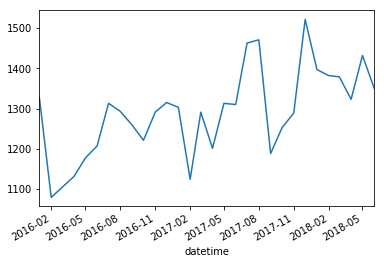

In [10]:
import matplotlib.pyplot as plt

df.groupby('datetime').count().category.plot()
plt.show()

# Plot some maps

In [11]:
# Get google maps api key, I keep mine in a text file called google_api_key

def get_google_api_key(path='google_api_key'):
    with open('google_api_key') as f:
        return str(f.readlines()[0])
    
google_api_key = get_google_api_key()

In [12]:
import gmaps
import gmaps.datasets

gmaps.configure(api_key=google_api_key)

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(df[['latitude','longitude']]))
fig

Figure(layout=FigureLayout(height='420px'))